In [ ]:
#Import Library
import os
import shutil
import glob

In [ ]:
#Drive Mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#GPU 
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#데이터를 배열로 초기화
data = {}
data['crack'] = []
data['uncrack'] = []

In [ ]:
#Crack Data
src = '/content/drive/MyDrive/딥러닝 오소리 /Data Set/10000 DataSet/Positive'
for jpgImage in glob.iglob(os.path.join(src, '*jpg')):
    data['crack'].append(jpgImage)
print(len(data['crack']))

10000


In [ ]:
#Uncrack Data
src = '/content/drive/MyDrive/딥러닝 오소리 /Data Set/10000 DataSet/Negative'
for jpgImage in glob.iglob(os.path.join(src, '*jpg')):
    data['uncrack'].append(jpgImage)
print(len(data['uncrack']))

10000


In [ ]:
#훈련에 필요한 파일 생성
os.mkdir('master_data_concrete')
os.mkdir('master_data_concrete/training')
os.mkdir('master_data_concrete/testing')

os.mkdir('master_data_concrete/training/crack')
os.mkdir('master_data_concrete/training/uncrack')
os.mkdir('master_data_concrete/testing/crack')
os.mkdir('master_data_concrete/testing/uncrack')

In [ ]:
#test data 추가

In [ ]:
#60% = 훈련용 데이터 // 40% = 테스트 데이터 각각 이미지 파일 복사
#이 과정은 직접 이미지 파일을 사전에 복사 함 으로써 해결가능 그러나 그렇게 되면 능동적인 활용은 안된다.
split_size = 0.60
for class_type, imagesList in data.items():
    train_size = int(split_size*(len(imagesList)))
    train_images_list = imagesList[:train_size]
    test_images_list = imagesList[train_size:]
    
    base_dest = 'master_data_concrete'
    #copy training  images of crack type
    for image in train_images_list:
        dest = os.path.join(base_dest, 'training', class_type)
        shutil.copy(image, dest)

    #copy testing images of crack type
    for image in test_images_list:
        dest = os.path.join(base_dest, 'testing', class_type)
        shutil.copy(image, dest)

In [ ]:
#test 셔플 6:2:2 의 비율로 


In [1]:
#Model Library
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.callbacks import EarlyStopping, LambdaCallback
from keras.layers import Activation, Dropout,Input, Flatten, Dense
from keras.applications import ResNet50
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#Convolutional Layer
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3))) #227로 변경
model.add(BatchNormalization()) #배치 정규화
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [3]:
#Output Layer
model.add(Flatten())  #3D를 1D로 벡터 변환
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1)) 
model.add(BatchNormalization())#this ===== 
model.add(Activation('sigmoid'))  #or model.add(Activation('softmax')) // two output softmax == one output sigmoid

In [ ]:
model.summary()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 60
epochs = 5

#스케일 조정 및 과적합 방지
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
         #그레이스케일 추가 1
        zoom_range=0.2,
        horizontal_flip=True)

#test에 사용할 확장구성
test_datagen = ImageDataGenerator(rescale=1./255)

#테스트, 검증데이터의 모든 이미지 크기 = 227*227
train_generator = train_datagen.flow_from_directory(
        '/content/master_data_concrete/training',  
        target_size=(227, 227), 
        batch_size=batch_size,
        #그레이스케일 추가 2
        class_mode='binary')   #binary_crossentropy loss를 사용하기 위한 binary label

#검증 데이터
validation_generator = test_datagen.flow_from_directory(
        '/content/master_data_concrete/testing',
        target_size=(227, 227),
        batch_size=batch_size,
        class_mode='binary')

Found 12000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


In [ ]:
#만약 overfitting, underfitting 을 일으키면 EarlyStopping을 쓰기 위한 코드
#patience가 5면 validation score가 5회 이상 개선이 없을때 훈련을 멈춘다

#from keras.callbacks import EarlyStopping
#es = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=0.005)

In [ ]:
#Model Learning
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #rmsprop or adam , accuracy or f1-score  (positive와 negative의 데이터 값 차이가 높을 경우)
history = model.fit_generator(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator) #callbacks=[es])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
200/200 [==============================] - 147s 725ms/step - loss: 0.3569 - accuracy: 0.9566 - val_loss: 0.9118 - val_accuracy: 0.5000
Epoch 2/5
200/200 [==============================] - 145s 723ms/step - loss: 0.2757 - accuracy: 0.9907 - val_loss: 0.4293 - val_accuracy: 0.8043
Epoch 3/5
200/200 [==============================] - 144s 721ms/step - loss: 0.2319 - accuracy: 0.9939 - val_loss: 0.3561 - val_accuracy: 0.8633
Epoch 4/5
200/200 [==============================] - 144s 720ms/step - loss: 0.1960 - accuracy: 0.9951 - val_loss: 0.1941 - val_accuracy: 0.9855
Epoch 5/5
200/200 [==============================] - 144s 721ms/step - loss: 0.1701 - accuracy: 0.9957 - val_loss: 0.1721 - val_accuracy: 0.9916


In [ ]:
#test data검증

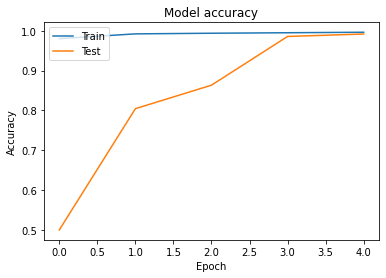

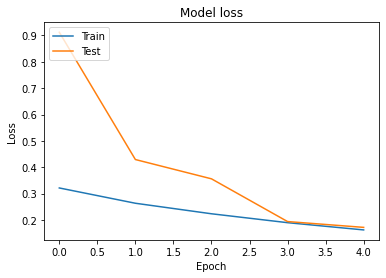

In [ ]:
#훈련 및 검증 정확도 시각화
#학습 정확성 값과 검증 정확성 값
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 학습 손실 값과 검증 손실 값
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
model.save_weights('first_try.h5')

In [ ]:
model.evaluate_generator(validation_generator)

In [ ]:
import cv2
import numpy as np
from PIL import Image
from torchvision import datasets, models, transforms
def predict(model, test_image, print_class = False):
     
    transform = transform['val']
     
    test_image_tensor = transform(test_image)
 
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 227, 227)
     
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(1, dim=1)
        class_name = idx_to_class[topclass.cpu().numpy()[0][0]]
        if print_class:
            print("Output class :  ", class_name)
    return class_name

In [ ]:
def predict_on_crops(input_image, height=227, width=227, save_crops = False):
    im = cv2.imread(input_image)
    imgheight, imgwidth, channels = im.shape
    k=0
    output_image = np.zeros_like(im)
    for i in range(0,imgheight,height):
        for j in range(0,imgwidth,width):
            a = im[i:i+height, j:j+width]
            ## discard image cropss that are not full size
            predicted_class = predict(history,Image.fromarray(a))
            ## save image
            file, ext = os.path.splitext(input_image)
            image_name = file.split('/')[-1]
            folder_name = 'out_' + image_name
            ## Put predicted class on the image
            if predicted_class == 'Positive':
                color = (0,0, 255)
            else:
                color = (0, 255, 0)
            cv2.putText(a, predicted_class, (50,50), cv2.FONT_HERSHEY_SIMPLEX , 0.7, color, 1, cv2.LINE_AA) 
            b = np.zeros_like(a, dtype=np.uint8)
            b[:] = color
            add_img = cv2.addWeighted(a, 0.9, b, 0.1, 0)
            ## Save crops
            if save_crops:
                if not os.path.exists(os.path.join('/content/drive/MyDrive/딥러닝 오소리 /Data Set/real_images', folder_name)):
                    os.makedirs(os.path.join('/content/drive/MyDrive/딥러닝 오소리 /Data Set/real_images', folder_name))
                filename = os.path.join('/content/drive/MyDrive/딥러닝 오소리 /Data Set/real_images', folder_name,'img_{}.png'.format(k))
                cv2.imwrite(filename, add_img)
            output_image[i:i+height, j:j+width,:] = add_img
            k+=1
    ## Save output image
    cv2.imwrite(os.path.join('/content/drive/MyDrive/딥러닝 오소리 /Data Set/real_images','predictions', folder_name+ '.jpg'), output_image)
    return output_image

In [ ]:
plt.figure(figsize=(10,10))
output_image = predict_on_crops('/content/drive/MyDrive/딥러닝 오소리 /Data Set/real_images/concrete_crack1.jpg', 128, 128)
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))

UnboundLocalError: ignored

<Figure size 720x720 with 0 Axes>